gym.. pytorch로 DQN돌려보기

https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
위 링크보고 따라해본거

인스톨정보..
pytorch

https://pytorch.org/ 여기보고 

conda install pytorch torchvision -c pytorch

위처럼 명령어 실행함




torchvision

https://anaconda.org/soumith/torchvision 여기보고

conda install -c soumith torchvision 

conda install -c soumith/label/pytorch torchvision 


위처럼 명령어 차례대로 실행함

전반적인소감 : 별로 어려울거 없고 평이하게 잘 작성되어 있고 딥마인드의 핵심개념인 리플레이메모리랑, 스테이셔너리가 잘 구현돼 있다.


The CartPole task is designed so that the inputs to the agent are 4 real values representing the environment state (position, velocity, etc.). 

인풋은 이런거고..

However, neural networks can solve the task purely by looking at the scene, so we’ll use a patch of the screen centered on the cart as an input. Because of this, our results aren’t directly comparable to the ones from the official leaderboard - our task is much harder. 

오호.. 이미지로 하는거구만 ㅇㅋ

아래 군데군데 주석달아놨으니까 나중에 참고하시라

In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [2]:
device

device(type='cpu')

In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

# 최근 state전이 pair 만개를 저장해두고 그야말로 랜덤하게 128개 배치뽑아서 트레이닝
class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
# I need to check that below class is same thing as deepmind version
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.head = nn.Linear(448, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

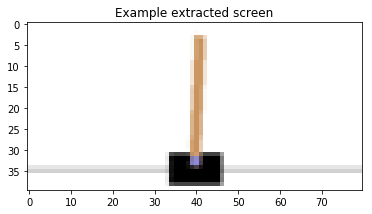

In [5]:
# 아래 get_screen() 이함수는 다른 때에도 활용도가 있을듯!!
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

# This is based on the code from gym.
screen_width = 600


def get_cart_location():
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART


# pyplot에서 rgb버퍼를 가져오는 코드인데.. 재밌는건 cart위치 중심으로 crop을 한다. 이것 때문에 stackoverflow에도 말이 있던데
# 이 crop을 하지 않으면 잘 학습이 안된다고 한다.. 
def get_screen():
    screen = env.render(mode='rgb_array').transpose(
        (2, 0, 1))  # transpose into torch order (CHW)
    # Strip off the top and bottom of the screen
    screen = screen[:, 160:320]
    view_width = 320
    cart_location = get_cart_location()
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescare, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)


env.reset()
plt.figure()
# 아래는 내가 rgb버퍼가 있을때 pyplot에다가 그릴수 있는 기능이다. 알아두면 좋겠지??
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [6]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


# 입실론 그리디가 적용되어 있고 입실론은 시간이 갈수록 줄어드는 구조인듯하다(EPS_DECAY)
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(2)]], device=device, dtype=torch.long)


episode_durations = []

# 요거는 에피소드가 진행됨에 따라 몇스텝이나 살아남았는지를 y축에 두고 누적그래프를 그려주는 코드이다.
def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [7]:
# 아래코드가 학습에 있어서 핵심인데..
# Q(s_t, a)랑 max Q(s_t+1, a)를 둘다 구해서 로스구하고 역전파하는 방식인데..
# stationary를 위해서 왼쪽거는 policy network, 오른쪽꺼는 target network을 사용하고
# target network은 10번 에피소드에 한번씩만 policy network과 동기화 해주는 구조 (어려운 개념은 없다.)
# 아래에서 배치사이즈 만큼 한번에 step돌리는거 같은데 그 구체적인 방법에 대해서 자세히 보지는 않았다. 나중에는 한번쯤은 봐야할듯
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation).
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        # 요개 내부 파라미터를 -1에서 1사이로 매번 조정해주는 기능같은데.. 왜 쓰는지 모르겠다.
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [8]:
# 아래가 메인루프라고 할 수 있겠다.
# 이게 돌려보니까.. 입실론 그리디에서 랜덤으로 빠질때는 에피소드는 하나 소모되지만 실제 네트웍학습은 스킵되고
# 리플레이 메모리 사이즈가 배치사이즈보다 작을때도 스킵되는등 초반에는 허수가 있다.
# 실제로는 50은 택도없고 꽤나 큰수가 돼야 수렴되기 시작하는걸로 보인다.

# 그리고 reward구조를 보면 step을 돌렸을때 살아남기만 하면 1.0을 주고
# pole의 기울기가 너무 커지면 done이 True가 되면서 에피소드가 끝나는 구조이다.
# 마지막에 done이 True일때 reward가 0으로 반영되는지는 확인안해봤는데 나중에 확인해보자. 0이라면 터미널 패널티가 있는 셈일듯 
num_episodes = 50
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # Update the target network
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

<Figure size 432x288 with 0 Axes>

Complete


<Figure size 432x288 with 0 Axes>